---

### Задача 1.

*Задача простая, расписана подробно, помогает разобраться в разных деталях.*

При проведении испытания лекарства получены следующие данные. В каждом случае указано количество успешных случаев.


| Количество успешных        | Принимали плацебо | Принимали лекарство  |
| :------------- |-------------:| -----:|
| Низкое давление      | 81 из 87 | 234 из 270 |
| Высокое давление     | 192 из 263      |   55 из 80 |


Требуется оценить эффект влияния лекарства на успех в двух следующих случаях.

* Кровяное давление пациентов измерялось до начала испытания, после чего принималось решение о приеме лекарства.

* Кровяное давление пациентов измерялось в конце испытания. При этом известно, что лекарство может оказывать эффект на кровяное давление, которое в свою очередь может оказывать эффект на выздоровление. 

Часть этой задачи мы уже разобрали на занятии. Сейчас давайте на ее примере разберемся досконально в разных тонкостях.

**1.** Выполните следующие действия для каждого случая.


- Нарисуйте граф причинно-следственных связей для каждого случая. 
- Выпишите плотность марковского распределения на графе.
- Определите численно оценку каждой компоненты плотности. Все распределения дискретны, поэтому надо указать оценки всех необходимых условных вероятностей.

**2.** Сначала все посчитаем ручками. 

* Посчитайте обычную оценку эффекта (ассоциация) между исследуемыми группами (лекарство/плацебо). Сравните с эффектом по группам относительно низкого и высокого давления.


* Посчитайте оценку причинно-следственного эффекта (ATE) с помощью интервенции, поясняя, что означает каждая величина в выражении. 


* Посчитайте оценку причинно-следственного эффекта на экспериментальной группе (ATT) с помощью интервенции, поясняя, что означает каждая величина в выражении. 


* Посчитайте оценку смещения между группами. *См. утверждение с лекции.*

Сделайте выводы.

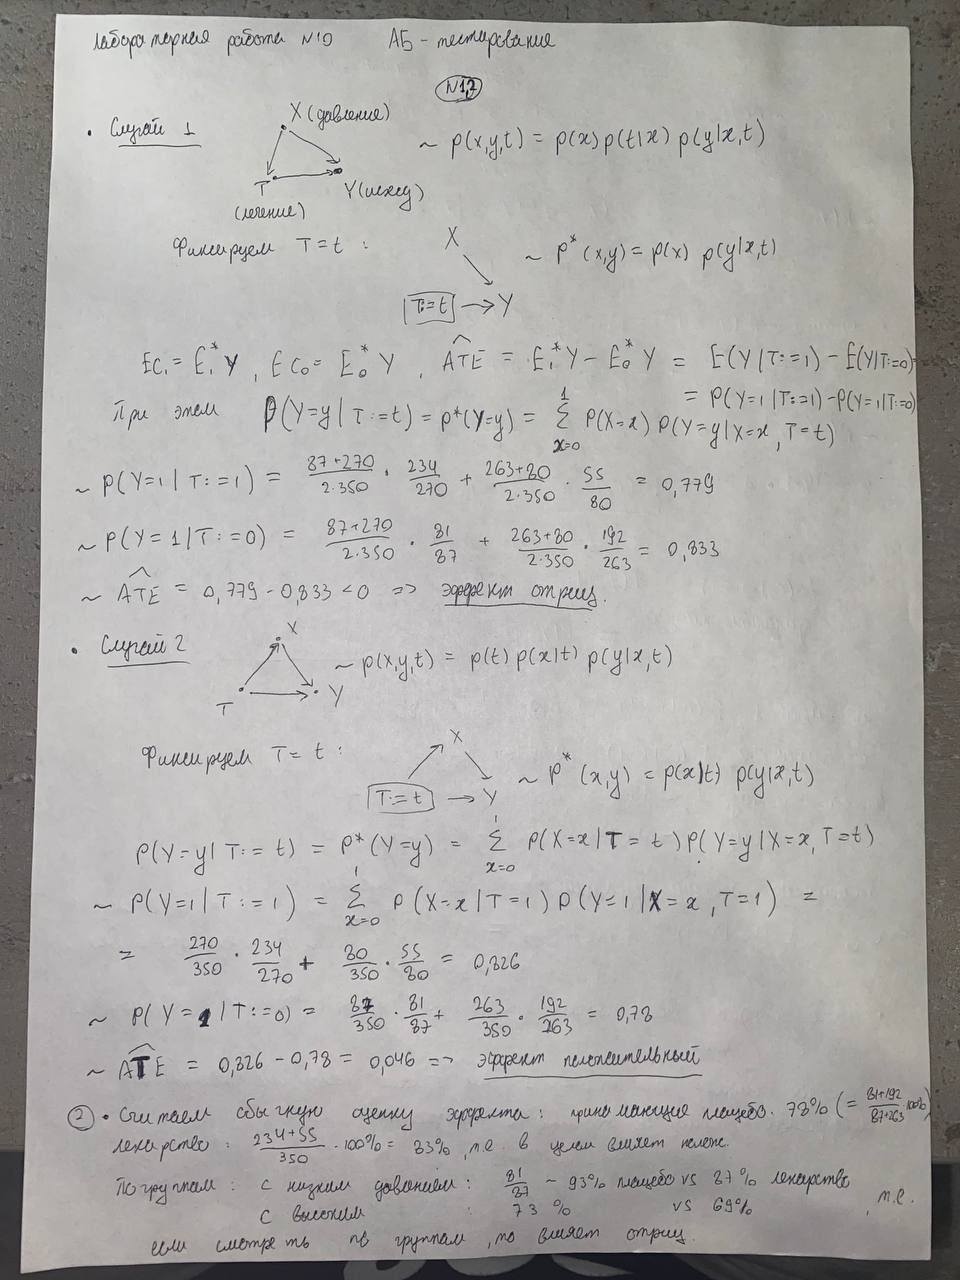

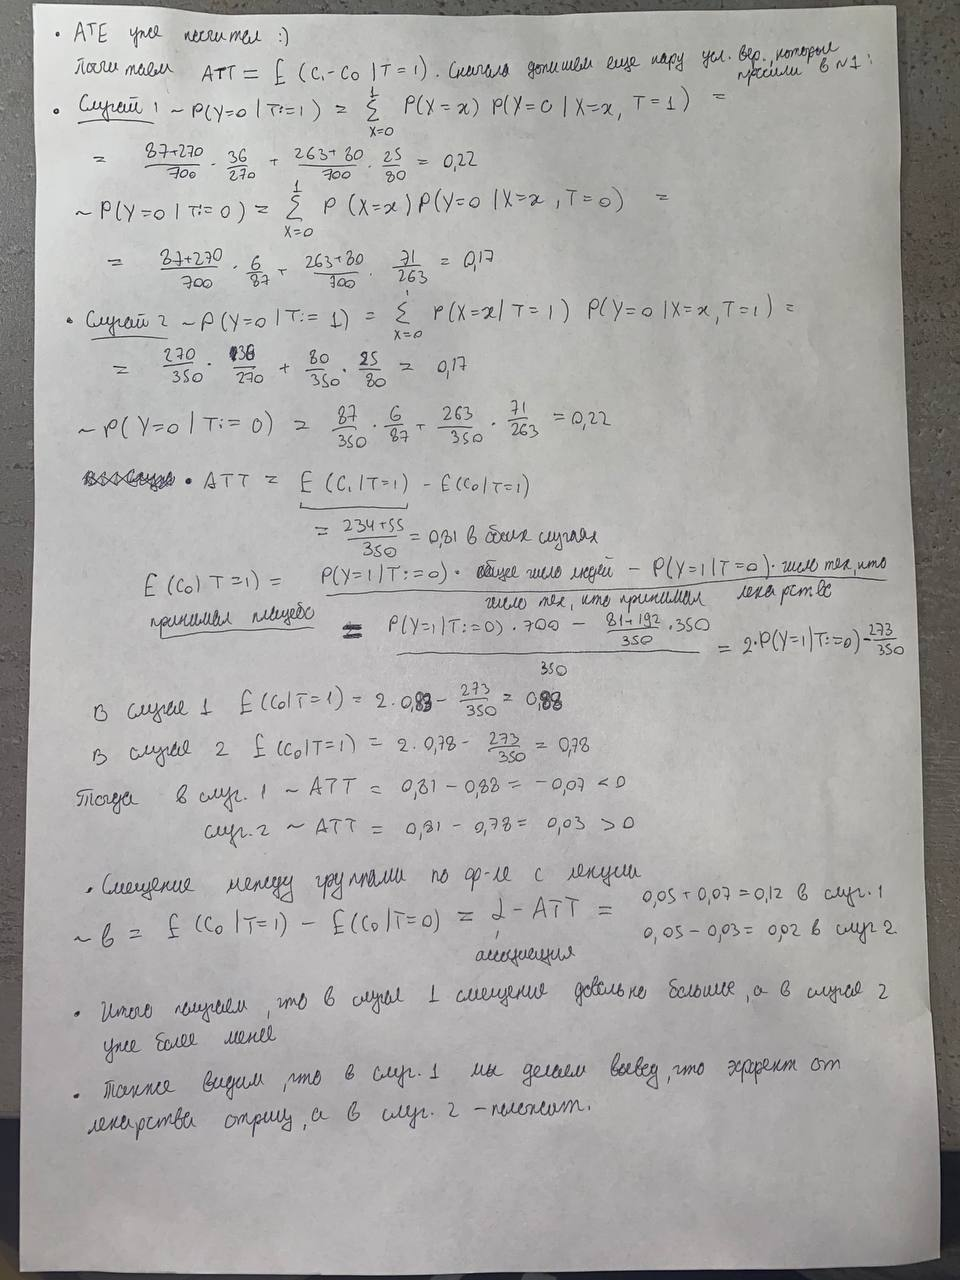

**3.** Поэкспериментируем с библиотекой DoWhy. Зададим датасет с данными, которые соответствуют нашей задаче

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import networkx as nx
from dowhy import gcm

In [3]:
data = pd.DataFrame()
data['treatment'] = [0]*(87+263) + [1]*(270+80)
data['blood_pressure'] = [0]*87 + [1]*263 + [0]*270 + [1]*80
data['result'] = [1]*81 + [0]*(87-81) + [1]*192 + [0]*(263-192) \
                + [1]*234 + [0]*(270-234) + [1]*55 + [0]*(80-55)
data.index.name = 'patient'

data

,treatment,blood_pressure,result
patient,,,
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
695,1,1,0
696,1,1,0
697,1,1,0


Задайте граф причинно-следственных связей и постройте по нему модель `StructuralCausalModel` с автоматическим определением механизма причинно-следственных связей. Обучите полученную модель

In [87]:
# Случай 1, задаем граф

causal_graph = nx.DiGraph([
    ('blood_pressure', 'treatment'), 
    ('blood_pressure', 'result'),
    ('treatment', 'result')
])

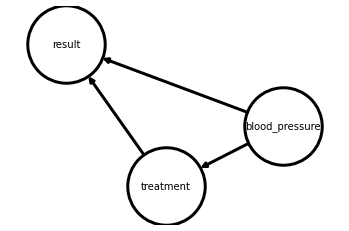

In [91]:
# Смотрим какой он получился

options = {
    "font_size": 10,
    "node_size": 6000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 3,
    "width": 3,
}

nx.draw_networkx(causal_graph, **options)
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

In [6]:
causal_model = gcm.StructuralCausalModel(causal_graph)

In [7]:
gcm.auto.assign_causal_mechanisms(causal_model, data) # автоматическое определение механизма причинно-следственных связей

In [8]:
gcm.fit(causal_model, data) # обучаем модель

Fitting causal mechanism of node result: 100%|██████████| 3/3 [00:00<00:00, 32.32it/s]


Выясните, какие зависимости подобрались и напечатайте параметры этих моделей

In [9]:
model_X = causal_model.causal_mechanism('blood_pressure')
model_X

Эмпирическое распределение на blood_pressure, так как это признак не зависит от других

In [10]:
model_T = causal_model.causal_mechanism('treatment')
model_T

In [13]:
sklearn_model = model_T.prediction_model.sklearn_model # достаем sklearn'овскую модель
sklearn_model.coef_, sklearn_model.intercept_  # смотрим на полученные коэффициенты

(array([-0.52306637]), 0.7563025210084036)

Тут обучилась линейная зависимость (аддитивная модель с шумом) от blood_pressure, то есть $treatment = a + b * blood\_pressure + ɛ$

Коэффициент при blood_pressure отрицательный, то есть лечение зависит обратно пропорционально давлению

In [14]:
model_Y = causal_model.causal_mechanism('result')
model_Y

Тут тоже аддитивная модель с шумом

In [16]:
sklearn_model = model_Y.prediction_model.sklearn_model # достаем sklearn'овскую модель
sklearn_model

HistGradientBoostingRegressor()

А тут у нас оказался градиентный бустинг от двух признаков: blood_pressure и treatment

Как видим, были использованы модели с аддитивным шумом, в то время как наши данные дискретны.

Поменяем тип данных на строковые

In [18]:
data = data.astype(str)

Задайте модели наследования вручную. Если у вершины нет предков, то используйте эмпирическое распределение, иначе &mdash; классификатор `gcm.ClassifierFCM()`. Обучите полученную causal модель

In [19]:
causal_model.set_causal_mechanism(
    'blood_pressure', gcm.EmpiricalDistribution()
)
causal_model.set_causal_mechanism(
    'treatment', gcm.ClassifierFCM()
)
causal_model.set_causal_mechanism(
    'result', gcm.ClassifierFCM()
)

In [20]:
gcm.fit(causal_model, data)

Fitting causal mechanism of node result: 100%|██████████| 3/3 [00:00<00:00, 20.75it/s]


Наконец, посчитайте оценку ATE с помощью интервенции в построенной модели. Не забудьте, что в качестве значения интервенции нужно указать строку, а полученные семплы перевести обратно в числа перед усреднением.

In [21]:
samples = gcm.interventional_samples(
    causal_model,
    {'treatment': lambda y: '1' },  # условие интервенции
    num_samples_to_draw=100_000  # количество семплирований
)
samples.head()

,blood_pressure,treatment,result
0,0,1,0
1,0,1,1
2,1,1,0
3,1,1,0
4,0,1,0


In [23]:
p1 = samples.result.apply(lambda x: x == '1').mean()
p1

0.78043

Очень похоже на $P(Y = 1 | Y := 1)$, которое мы получили ручками

In [24]:
samples = gcm.interventional_samples(
    causal_model,
    {'treatment': lambda y: '0' },  # условие интервенции
    num_samples_to_draw=100_000  # количество семплирований
)
p2 = samples.result.apply(lambda x: x == '1').mean()
p2

0.83131

In [25]:
ATE = p1 - p2
ATE

-0.050880000000000036

То есть эффект от лекарства отрицательный

Сравните результаты с теми, которые посчитали ручками

Такой же результат вышел, значит, мы молодцы

Теперь быстренько для второго случая:

In [26]:
causal_graph = nx.DiGraph([
    ('treatment', 'blood_pressure'), 
    ('blood_pressure', 'result'),
    ('treatment', 'result')
])

In [27]:
causal_model = gcm.StructuralCausalModel(causal_graph)

In [28]:
causal_model.set_causal_mechanism(
    'treatment', gcm.EmpiricalDistribution()
)
causal_model.set_causal_mechanism(
    'blood_pressure', gcm.ClassifierFCM()
)
causal_model.set_causal_mechanism(
    'result', gcm.ClassifierFCM()
)

In [29]:
gcm.fit(causal_model, data)

Fitting causal mechanism of node result: 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]


In [31]:
samples = gcm.interventional_samples(
    causal_model,
    {'treatment': lambda y: '1' },  # условие интервенции
    num_samples_to_draw=100_000  # количество семплирований
)
p1 = samples.result.apply(lambda x: x == '1').mean()

samples = gcm.interventional_samples(
    causal_model,
    {'treatment': lambda y: '0' },  # условие интервенции
    num_samples_to_draw=100_000  # количество семплирований
)
p2 = samples.result.apply(lambda x: x == '1').mean()

ATE = p1 - p2

p1, p2, ATE

(0.82475, 0.78036, 0.04438999999999993)

Снова получили также, как мы делали ручками. При этом в данном случае эффект от лекарства положительный

---

### Задача 2.

**1.** Рассмотрим данные по заболеваемости и смертности от COVID-19 в марте 2020 года когда пандемия только начиналась. В данных представлена информация по нескольким странам по разным возрастным категориям. 

Считайте данные и посчитайте Case Fatality Rate (CFR) &mdash; процент смертности при условии подтвержденного коронавируса

In [116]:
data = pd.read_excel('covid_data.xlsx')
data = data.drop('Unnamed: 0', axis = 1)
data.head()

,Country,Age group,Confirmed cases,Confirmed fatalities
0,Italy,0-9,43,0
1,Italy,10-19,85,0
2,Italy,20-29,296,0
3,Italy,30-39,470,0
4,Italy,40-49,891,1


In [37]:
CFR = data['Confirmed fatalities'].sum() /  data['Confirmed cases'].sum()
CFR

0.06973765634669117

То есть смертность 7%

Будем рассматривать Китай и Италию как довольно разные страны, в которых коронавирус в начале 2020 развивался наиболее стремительно.

Постройте гистограмму для сравнения CFR двух стран по возрастным категориям. Используйте для этого один вызов `seaborn.barplot` с некоторыми параметрами.

In [46]:
data.Country.value_counts()

Italy           9
Argentina       9
China           9
Colombia        9
Diam. Princ.    9
Netherlands     9
Portugal        9
South Africa    9
Spain           9
Sweden          9
Switzerland     9
South Korea     9
Name: Country, dtype: int64

In [38]:
import seaborn

In [71]:
Italy_China = pd.concat((data[data.Country == 'Italy'], data[data.Country == 'China']), axis = 0)
Italy_China

,Country,Age group,Confirmed cases,Confirmed fatalities
0,Italy,0-9,43,0
1,Italy,10-19,85,0
2,Italy,20-29,296,0
3,Italy,30-39,470,0
4,Italy,40-49,891,1
5,Italy,50-59,1453,3
6,Italy,60-69,1471,37
7,Italy,70-79,1785,114
8,Italy,80+,1532,202
18,China,0-9,416,0


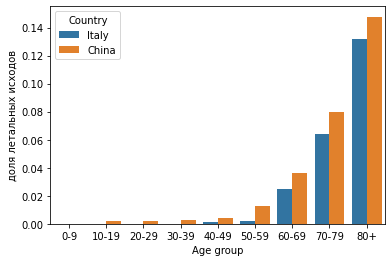

In [51]:
seaborn.barplot(data=Italy_China, x='Age group', y=Italy_China['Confirmed fatalities'] / Italy_China['Confirmed cases'], hue = 'Country')
plt.ylabel('доля летальных исходов')
plt.show()

В китае в любой возрастной категории доля летальных исходов больше

Теперь посчитайте общую CFR на основе суммарного количества случаев по всем категориями и сравните их для этих двух стран.

In [52]:
# Для Италии:
Italy_China[Italy_China.Country == 'Italy']['Confirmed fatalities'].sum() \
                / Italy_China[Italy_China.Country == 'Italy']['Confirmed cases'].sum()

0.04448043857463244

In [53]:
# Для Китая:
Italy_China[Italy_China.Country == 'China']['Confirmed fatalities'].sum() \
                / Italy_China[Italy_China.Country == 'China']['Confirmed cases'].sum()

0.02290025071633238

Что можно наблюдать?

Для групп по отдельность в Китае все хуже, а в совокупности получаем, что смертность в Китае ниже

**2.** Итак, мы исследуем три признака: страна, возрастная категория, CFR. Определите на них граф причинно-следственных связей на основе логических соображений и визуализируйте его.

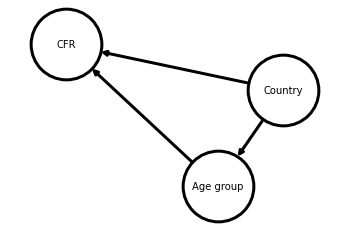

In [115]:
causal_graph = nx.DiGraph([
    ('Country', 'CFR'),
    ('Age group', 'CFR'),
    ('Country', 'Age group')
])
# Определил так, так как на CFR влияет все, а возраст людей зависит от демографии в стране

options = {
    "font_size": 10,
    "node_size": 5000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 3,
    "width": 3,
}

nx.draw_networkx(causal_graph, **options)
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

Для каждой вершины опишите характер причинно-следственной связи. Например, если это линейная регрессия, то надо выписать ее формулу.

In [117]:
data['CFR'] = data['Confirmed fatalities'] / data['Confirmed cases']
data = data.drop(['Confirmed fatalities','Confirmed cases'], axis = 1)
data

,Country,Age group,CFR
0,Italy,0-9,0.000000
1,Italy,10-19,0.000000
2,Italy,20-29,0.000000
3,Italy,30-39,0.000000
4,Italy,40-49,0.001122
...,...,...,...
103,South Korea,40-49,0.002026
104,South Korea,50-59,0.007549
105,South Korea,60-69,0.028364
106,South Korea,70-79,0.108484


CFR зависит от Age group как-то полиномиально, если посмотреть на визуализацию выше. При этом чем больше возраст, тем выше смертность

In [118]:
causal_model = gcm.StructuralCausalModel(causal_graph)

In [119]:
gcm.auto.assign_causal_mechanisms(causal_model, data)

In [120]:
gcm.fit(causal_model, data)

Fitting causal mechanism of node Age group: 100%|██████████| 3/3 [00:00<00:00,  6.67it/s]


In [121]:
model = causal_model.causal_mechanism('CFR')
sklearn_model = model.prediction_model.sklearn_model
sklearn_model

HistGradientBoostingRegressor()

То есть у нас обучился градиентный бустинг

In [79]:
model = causal_model.causal_mechanism('Age group')
model

Тут обучился классификатор для связи Country -> Age

**3.** Сделаем две копии признака "страна":
* `demography` ($D$) &mdash; демографическая ситуация, определяемая страной;
* `treatment methods` ($T$) &mdash; методы лечения, свойственные стране.

Мы делаем такое разделение потому как, например, одна страна может взять методы лечения другой страны, но демографическую ситуацию поменять при этом не получится.

Получается следующий причинно-следственный граф. Визуализируйте его

In [122]:
causal_graph = nx.DiGraph([
    ('demography', 'Age group'), 
    ('treatment methods', 'CFR'), 
    ('Age group', 'CFR')
])

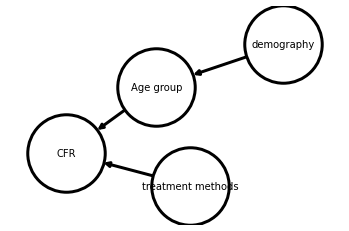

In [123]:
options = {
    "font_size": 10,
    "node_size": 6000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 3,
    "width": 3,
}

nx.draw_networkx(causal_graph, **options)
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

Определите по графу causal модель и обучите ее

In [124]:
# Надо чуть-чуть подправить данные

data['demography'] = data['Country']
data.columns = ['treatment methods', 'Age group', 'CFR', 'demography']
data.head()

,treatment methods,Age group,CFR,demography
0,Italy,0-9,0.000000,Italy
1,Italy,10-19,0.000000,Italy
2,Italy,20-29,0.000000,Italy
3,Italy,30-39,0.000000,Italy
4,Italy,40-49,0.001122,Italy


In [125]:
causal_model = gcm.StructuralCausalModel(causal_graph)
gcm.auto.assign_causal_mechanisms(causal_model, data)

In [126]:
gcm.fit(causal_model, data)

Fitting causal mechanism of node CFR: 100%|██████████| 4/4 [00:00<00:00, 45.67it/s]


С помощью интервенции оцените, было бы эффективнее применять в Китае с его демографической ситуацией итальянские методы лечения. Для этого нужно оценить величину
$$NDE = \mathsf{E}(CFR\ |\ D:=China, T:=Italy) - \mathsf{E}(CFR\ |\ D:=China, T:=China),$$
где NDE &mdash; Natural Direct Effect. Используйте достаточно большое количество семплирований.

In [127]:
samples = gcm.interventional_samples(
    causal_model,
    {'demography': lambda y: "China", 'treatment methods': lambda y: "Italy" },  # условия интервенции
    num_samples_to_draw=1_000_000  # количество семплирований
)
p1 = samples.CFR.mean()

In [128]:
p1

0.049519155162589264

In [129]:
samples = gcm.interventional_samples(
    causal_model,
    {'demography': lambda y: "China", 'treatment methods': lambda y: "China" },  # условия интервенции
    num_samples_to_draw=1_000_000  # количество семплирований
)
p2 = samples.CFR.mean()

In [130]:
p2

0.04967063120141002

In [131]:
p1 - p2

-0.00015147603882075672

Таким образом, было бы эффективнее применять Итальянские методы в Китае с его демографической обстановкой (так как матожидание смертности в этом случае меньше, что лучше)

Теперь, наоборот, оцените, было бы эффективнее применять в Италии с его демографической ситуацией китайские методы лечения.

In [132]:
samples = gcm.interventional_samples(
    causal_model,
    {'demography': lambda y: "Italy", 'treatment methods': lambda y: "China" },  # условия интервенции
    num_samples_to_draw=1_000_000  # количество семплирований
)
p1 = samples.CFR.mean()
p1

0.049662796218556404

In [133]:
samples = gcm.interventional_samples(
    causal_model,
    {'demography': lambda y: "Italy", 'treatment methods': lambda y: "Italy" },  # условия интервенции
    num_samples_to_draw=1_000_000  # количество семплирований
)
p2 = samples.CFR.mean()
p2

0.0494137074076878

То есть в Италии Итальянские методы бы были лучше, чем Китайские

Наконец, оценим, что было бы если в Китае с его методами лечения демографическая ситуация была бы такой же, как в Италии (Natural Indirect Effect). Какую величину при этом надо посчитать? Посчитайте ее.

Надо посчитать $$\mathsf{E}(CFR\ |\ D:=Italy, T:=China) - \mathsf{E}(CFR\ |\ D:=China, T:=China),$$

In [134]:
samples = gcm.interventional_samples(
    causal_model,
    {'demography': lambda y: "Italy", 'treatment methods': lambda y: "China" },  # условия интервенции
    num_samples_to_draw=1_000_000  # количество семплирований
)
p1 = samples.CFR.mean()

samples = gcm.interventional_samples(
    causal_model,
    {'demography': lambda y: "China", 'treatment methods': lambda y: "China" },  # условия интервенции
    num_samples_to_draw=1_000_000  # количество семплирований
)
p2 = samples.CFR.mean()

p1 - p2

0.00012810516385720894

То есть в Китае с его методами лечения и демографической ситуацией такой же, как в Италии, было бы хуже

**4.** Наконец, сравните между собой некоторые другие страны. Каким странам вы рекомендовали бы поменять методы лечения на начальном этапе?

In [143]:
data.demography.value_counts()

Italy           9
Argentina       9
China           9
Colombia        9
Diam. Princ.    9
Netherlands     9
Portugal        9
South Africa    9
Spain           9
Sweden          9
Switzerland     9
South Korea     9
Name: demography, dtype: int64

In [136]:
samples = gcm.interventional_samples(
    causal_model,
    {'demography': lambda y: "Argentina", 'treatment methods': lambda y: "Netherlands" },  # условия интервенции
    num_samples_to_draw=1_000_000  # количество семплирований
)
p1 = samples.CFR.mean()

samples = gcm.interventional_samples(
    causal_model,
    {'demography': lambda y: "Argentina", 'treatment methods': lambda y: "Argentina" },  # условия интервенции
    num_samples_to_draw=1_000_000  # количество семплирований
)
p2 = samples.CFR.mean()

if p1 < p2:
    print('Аргентине надо менять treatment на Голландский')
else:
    print('Аргентине НЕ надо менять treatment на Голландский')

Аргентине НЕ надо менять treatment на Голландский


In [138]:
samples = gcm.interventional_samples(
    causal_model,
    {'demography': lambda y: "South Africa", 'treatment methods': lambda y: "Spain" },  # условия интервенции
    num_samples_to_draw=1_000_000  # количество семплирований
)
p1 = samples.CFR.mean()

samples = gcm.interventional_samples(
    causal_model,
    {'demography': lambda y: "South Africa", 'treatment methods': lambda y: "South Africa" },  # условия интервенции
    num_samples_to_draw=1_000_000  # количество семплирований
)
p2 = samples.CFR.mean()

if p1 < p2:
    print('Африке надо менять treatment на Испанский')
else:
    print('Африке НЕ надо менять treatment на Испанский')

Африке НЕ надо менять treatment на Испанский


In [139]:
samples = gcm.interventional_samples(
    causal_model,
    {'demography': lambda y: "Portugal", 'treatment methods': lambda y: "Switzerland" },  # условия интервенции
    num_samples_to_draw=1_000_000  # количество семплирований
)
p1 = samples.CFR.mean()

samples = gcm.interventional_samples(
    causal_model,
    {'demography': lambda y: "Portugal", 'treatment methods': lambda y: "Portugal" },  # условия интервенции
    num_samples_to_draw=1_000_000  # количество семплирований
)
p2 = samples.CFR.mean()

if p1 < p2:
    print('Portugal надо менять treatment на Switzerland')
else:
    print('Portugal НЕ надо менять treatment на Switzerland')

Portugal надо менять treatment на Switzerland


In [148]:
samples = gcm.interventional_samples(
    causal_model,
    {'demography': lambda y: "South Korea", 'treatment methods': lambda y: "Colombia"},  # условия интервенции
    num_samples_to_draw=1_000_000  # количество семплирований
)
p1 = samples.CFR.mean()

samples = gcm.interventional_samples(
    causal_model,
    {'demography': lambda y: "South Korea", 'treatment methods': lambda y: "South Korea"},  # условия интервенции
    num_samples_to_draw=1_000_000  # количество семплирований
)
p2 = samples.CFR.mean()

if p1 < p2:
    print('South Korea надо менять treatment на Colombia')
else:
    print('South Korea НЕ надо менять treatment на Colombia')

South Korea надо менять treatment на Colombia


Так, ну мы уже выяснили, что Китаю, Южной Корее и Португалии точно надо было менять стратегию лечения. Посмотрим на остальные страны (некоторые)

Давайте посмотрим на такие пары стран:

In [161]:
for country1 in set(['Diam. Princ.', 'Switzerland', 'Sweden', 'Spain', 'Colombia']):
    for country2 in set(['Diam. Princ.', 'Switzerland', 'Sweden', 'Spain', 'Colombia']) - set([country1]):
        samples = gcm.interventional_samples(
            causal_model,
            {'demography': lambda y: country1, 'treatment methods': lambda y: country2},  # условия интервенции
            num_samples_to_draw=1_000_000  # количество семплирований
        )
        p1 = samples.CFR.mean()

        samples = gcm.interventional_samples(
            causal_model,
            {'demography': lambda y: country1, 'treatment methods': lambda y: country1},  # условия интервенции
            num_samples_to_draw=1_000_000  # количество семплирований
        )
        p2 = samples.CFR.mean()

        if p1 < p2:
            print(country1 + ' надо менять treatment на ' + country2)
            break
        else:
            print(country1 + ' НЕ надо менять treatment на ' + country2)

Sweden НЕ надо менять treatment на Switzerland
Sweden НЕ надо менять treatment на Diam. Princ.
Sweden надо менять treatment на Colombia
Diam. Princ. НЕ надо менять treatment на Sweden
Diam. Princ. НЕ надо менять treatment на Switzerland
Diam. Princ. НЕ надо менять treatment на Colombia
Diam. Princ. надо менять treatment на Spain
Switzerland НЕ надо менять treatment на Sweden
Switzerland надо менять treatment на Diam. Princ.
Colombia НЕ надо менять treatment на Sweden
Colombia НЕ надо менять treatment на Switzerland
Colombia НЕ надо менять treatment на Diam. Princ.
Colombia надо менять treatment на Spain
Spain НЕ надо менять treatment на Sweden
Spain НЕ надо менять treatment на Switzerland
Spain надо менять treatment на Diam. Princ.


По итогу для любой страны находится другая, методы лечения которой бы сработали лучше